In [ ]:
########################################################
#  Create Date:         4/24/2025
#  Design Name:         market_price_prediction_timeseries
#  Project:             Time Series Forecasting
#  Description:         Based on data collected by political science researcher Zachary M. Jones,
#  this project explores how crowdsourced market prices—submitted by users across the U.S.—respond
#  to policy shifts. By applying EWMA (Exponentially Weighted Moving Average) smoothing techniques
#  and trend-based forecasting, the analysis identifies patterns in regional price volatility and
#  long-term trends. This work reflects how data-driven methods can bring clarity to complex,
#  informal markets shaped by legislative changes.
#
#  Additional Comments:
#  Adapted from Allen B. Downey's
#  Think Stats 2nd Edition, Ch12 Time Series Analysis
#
########################################################

In [5]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")

In [6]:
import numpy as np
import pandas as pd
import statsmodels

import random


## Time series analysis

NOTE: Some of the example in this chapter have been updated to work with more recent versions of the libraries.

Load the data from "Price of Weed".

In [7]:
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [8]:
transactions.describe()

,price,amount,date,ppg,lat,lon
count,147070.000000,147070.000000,147070,147070.000000,146897.000000,146897.000000
mean,137.259516,15.336626,2012-10-21 08:25:34.289793792,10.670560,37.858994,-91.988509
min,4.000000,1.000000,2010-09-02 00:00:00,1.020000,24.675731,-124.399110
25%,50.000000,5.000000,2012-05-15 00:00:00,6.000000,33.990380,-104.804560
50%,100.000000,14.150000,2012-12-17 00:00:00,10.600000,38.952526,-86.785248
75%,200.000000,28.300000,2013-06-17 00:00:00,14.130000,41.598235,-79.107692
max,990.000000,28.300000,2014-05-13 00:00:00,34.980000,49.054587,-67.086970
std,120.217590,11.145683,NaN,5.622977,5.008867,16.545298


The following function takes a DataFrame of transactions and compute daily averages.

In [9]:
# Group by date and compute mean price per gram
grouped = transactions[["date", "ppg"]].groupby("date")
daily = grouped.mean()  # Using mean aggregation

# Calculate years since start
daily["date"] = daily.index  # Save index as column
start_date = daily.date.min()
daily["years"] = (daily.date - start_date).dt.total_seconds() / (365.25 * 24 * 60 * 60)


The following function returns a map from quality name to a DataFrame of daily averages.

In [10]:
groups = transactions.groupby("quality")
dailies = {}
groups = transactions[['date', 'ppg']].groupby('date')

for name, group in groups:
    # Group by date and get mean ppg
    daily = group[["date", "ppg"]].groupby("date").mean()

    # Add date column from index
    daily["date"] = daily.index

    # Calculate years since start
    start_date = daily.date.min()
    daily["years"] = (daily.date - start_date).dt.total_seconds() / (365.25 * 24 * 60 * 60)

    # Store in dictionary
    dailies[name] = daily



GroupByDay which computes the daily average price and returns `dailies`.

In [11]:
groups = transactions.groupby('quality')
dailies = {}

# Loop through quality groups and calculate daily stats
for quality, group in transactions.groupby('quality'):
    daily = group.groupby('date')['ppg'].mean().reset_index()
    start_date = daily['date'].min()
    daily['years'] = (daily['date'] - start_date).dt.total_seconds() / (365.25 * 24 * 3600)
    daily.set_index('date', inplace=True)
    dailies[quality] = daily

The following plots the daily average price for each quality.

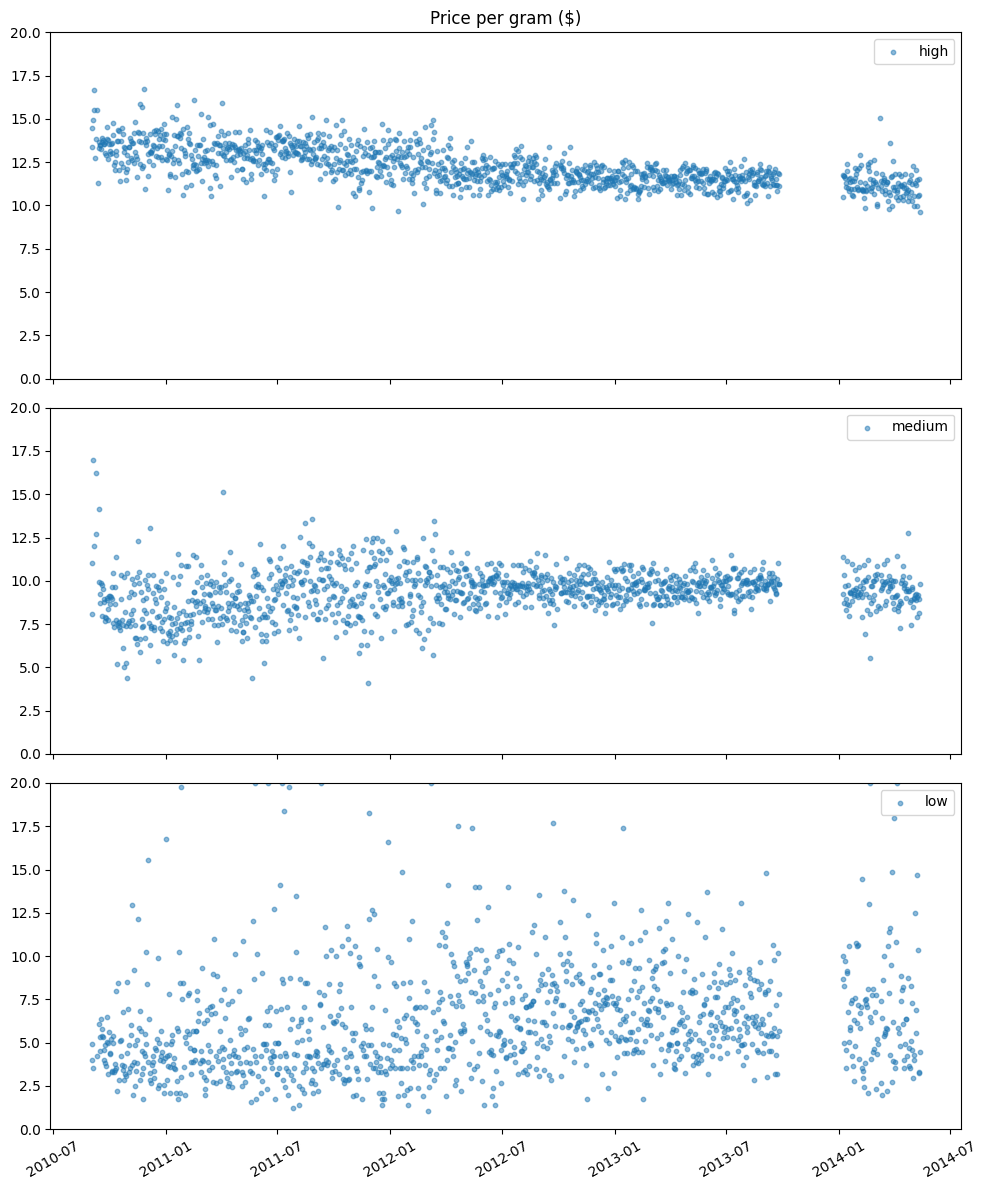

In [12]:
import matplotlib.pyplot as plt

qualities = ['high', 'medium', 'low']
fig, axes = plt.subplots(len(qualities), 1, figsize=(10, 12), sharex=True)

for ax, quality in zip(axes, qualities):
    daily = dailies[quality]
    ax.scatter(daily.index, daily['ppg'], s=10, alpha=0.5, label=quality)
    ax.set_ylim([0, 20])
    ax.legend(loc='upper right')

axes[0].set_title('Price per gram ($)')
axes[-1].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


We can use `statsmodels` to run a linear model of price as a function of time.

In [13]:
import statsmodels.formula.api as smf

# Fit linear regression for a single quality
model = smf.ols('ppg ~ years', data=daily)
results = model.fit()


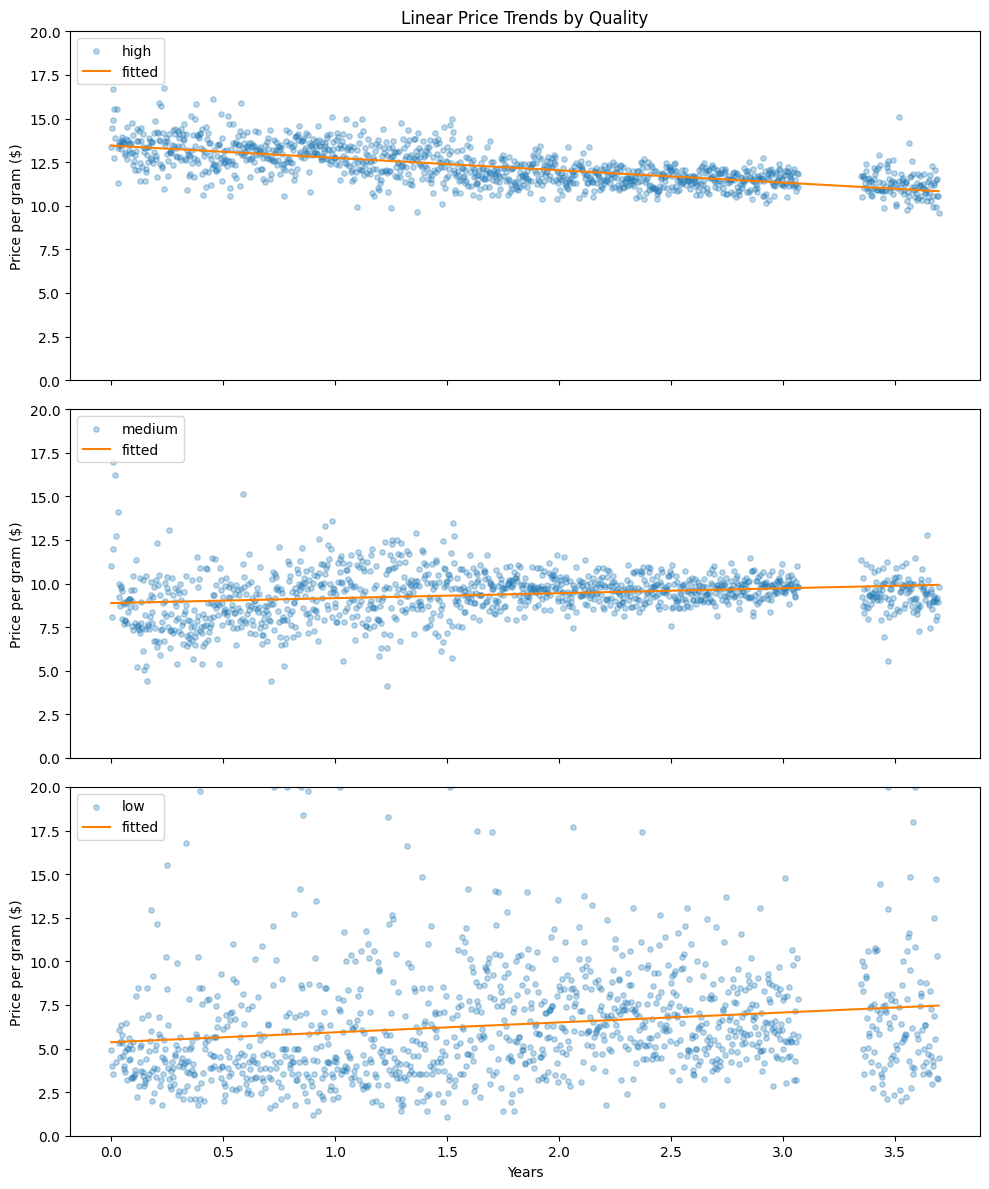

In [14]:
# Create vertical subplot layout for 3 quality levels
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

qualities = ['high', 'medium', 'low']

for ax, quality in zip(axes, qualities):
    daily = dailies[quality]
    model = smf.ols('ppg ~ years', data=daily).fit()

    # Scatter actual prices
    ax.scatter(daily['years'], daily['ppg'], s=15, alpha=0.3, label=quality)

    # Plot fitted regression line
    ax.plot(daily['years'], model.fittedvalues, color='#ff7f00', label='fitted')

    # Standardize y-axis range for comparability
    ax.set_ylim([0, 20])

    ax.set_ylabel('Price per gram ($)')
    ax.legend(loc='upper left')

axes[0].set_title('Linear Price Trends by Quality')
axes[-1].set_xlabel('Years')

plt.tight_layout()
plt.show()


Here's what the results look like.

In [15]:
results_list = []

for quality in qualities:
    daily = dailies[quality]
    model = smf.ols('ppg ~ years', data=daily).fit()

    results_list.append({
        'Quality': quality,
        'Intercept': f"{model.params['Intercept']:.3f}",
        'Slope': f"{model.params['years']:.3f}",
        'R²': f"{model.rsquared:.3f}"
    })

# Display regression summary
results_df = pd.DataFrame(results_list).set_index('Quality')
display(results_df)


,Intercept,Slope,R²
Quality,,,
high,13.450,-0.708,0.444
medium,8.879,0.283,0.050
low,5.362,0.568,0.030


The following function plots the original data and the fitted curve on high quality category.

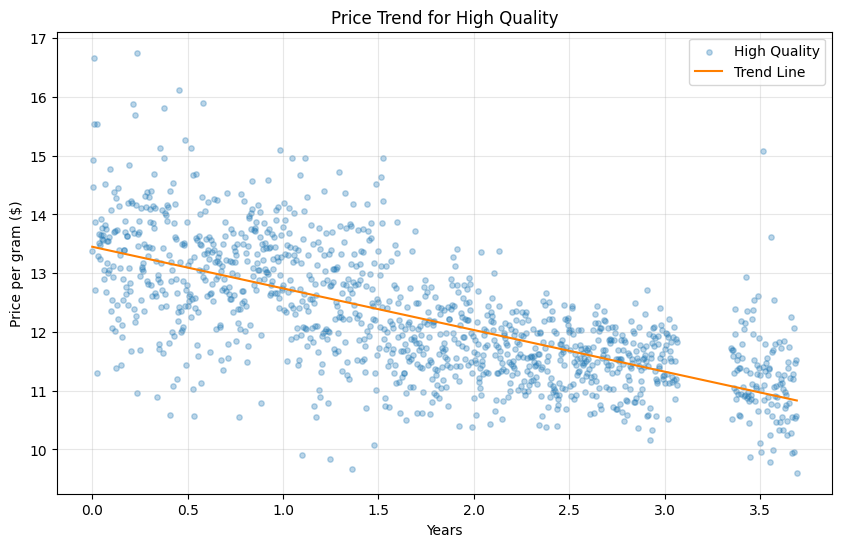

In [16]:
daily = dailies['high']
model = smf.ols('ppg ~ years', data=daily).fit()

plt.figure(figsize=(10, 6))
plt.scatter(daily['years'], daily['ppg'], s=15, alpha=0.3, label='High Quality')
plt.plot(daily['years'], model.fittedvalues, color='#ff7f00', label='Trend Line')

plt.title('Price Trend for High Quality')
plt.xlabel('Years')
plt.ylabel('Price per gram ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Moving averages

As a simple example, I'll show the rolling average of the numbers from 1 to 10.

In [17]:
array = np.arange(10)

With a "window" of size 3, we get the average of the previous 3 elements, or nan when there are fewer than 3.

In [18]:
series = pd.Series(array)
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

The following function plots the rolling mean and exponetially weighted moving average.

In [19]:
# # Get high quality data
# daily = dailies['high']
#
# # Create figure with two subplots side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
#
# # Create date range and reindex data
# dates = pd.date_range(daily.index.min(), daily.index.max())
# reindexed = daily.reindex(dates)
#
# # First subplot - Rolling Mean
# ax1.scatter(reindexed.index, reindexed.ppg, s=15, alpha=0.2, label='high')
# roll_mean = pd.Series(reindexed.ppg).rolling(30).mean()
# ax1.plot(reindexed.index, roll_mean, label='rolling mean', color='#ff7f00', linewidth=2)
# ax1.set_title('30-Day Rolling Mean')
# ax1.set_ylabel('price per gram ($)')
# ax1.tick_params(axis='x', rotation=30)
# ax1.legend()
# ax1.grid(True, alpha=0.3)
#
# # Second subplot - EWMA
# ax2.scatter(reindexed.index, reindexed.ppg, s=15, alpha=0.2, label='high')
# ewma = pd.Series(reindexed.ppg).ewm(span=30).mean()
# ax2.plot(reindexed.index, ewma, label='EWMA', color='#ff7f00', linewidth=2)
# ax2.set_title('Exponentially Weighted Moving Average')
# ax2.set_ylabel('price per gram ($)')
# ax2.tick_params(axis='x', rotation=30)
# ax2.legend()
# ax2.grid(True, alpha=0.3)
#
# plt.tight_layout()
# plt.show()

In [20]:
# Get high quality data
daily = dailies['high']

# Create full date range and reindex
dates = pd.date_range(daily.index.min(), daily.index.max())
reindexed = daily.reindex(dates)

# Calculate EWMA
ewma = reindexed['ppg'].ewm(span=30).mean()

# Residuals for realistic fill
resid = (reindexed['ppg'] - ewma).dropna()

# Fill missing values using EWMA + random residuals
nan_mask = reindexed['ppg'].isna()

# Create random residuals of the correct size
# Generate realistic noise based on residuals
noise = np.random.choice(resid, size=nan_mask.sum())

# Fill missing values with EWMA + noise
filled_data = reindexed['ppg'].copy()
filled_data[nan_mask] = ewma[nan_mask] + noise

Here is the 30 day rolling mean for the high quality category (left) and EWMA (right) which gives more weight to more recent points.

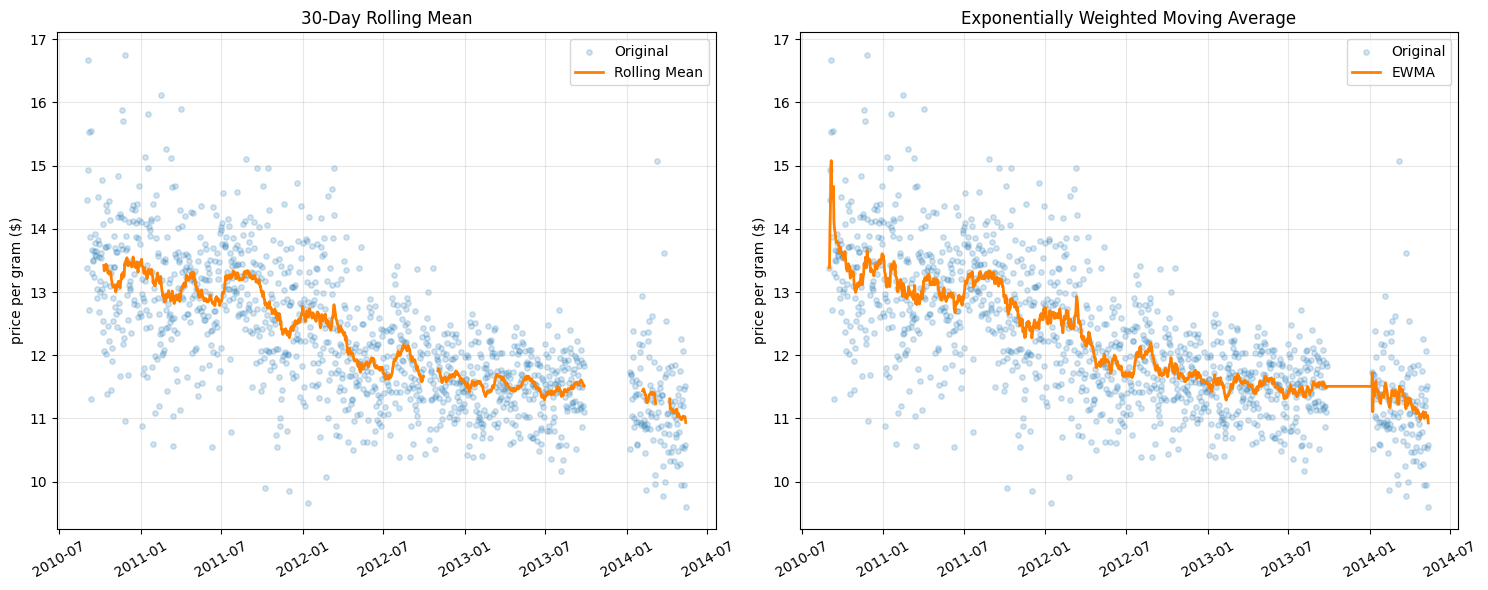

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Rolling mean
roll_mean = reindexed['ppg'].rolling(30).mean()
ax1.scatter(reindexed.index, reindexed['ppg'], s=15, alpha=0.2, label='Original')
ax1.plot(reindexed.index, roll_mean, color='#ff7f00', linewidth=2, label='Rolling Mean')
ax1.set_title('30-Day Rolling Mean')
ax1.set_ylabel('price per gram ($)')
ax1.tick_params(axis='x', rotation=30)
ax1.legend()
ax1.grid(True, alpha=0.3)

# EWMA
ax2.scatter(reindexed.index, reindexed['ppg'], s=15, alpha=0.2, label='Original')
ax2.plot(reindexed.index, ewma, color='#ff7f00', linewidth=2, label='EWMA')
ax2.set_title('Exponentially Weighted Moving Average')
ax2.set_ylabel('price per gram ($)')
ax2.tick_params(axis='x', rotation=30)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We can use resampling to generate missing values with the right amount of noise.

In [22]:
# # triple panel data
# # Get high quality data
# daily = dailies['high']
#
# # Create figure with three subplots
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
#
# # Create date range and reindex data
# dates = pd.date_range(daily.index.min(), daily.index.max())
# reindexed = daily.reindex(dates)
#
# # 1. Original data with missing values
# ax1.scatter(reindexed.index, reindexed.ppg, s=15, alpha=0.3, label='Original data')
# ax1.set_title('Original Data with Missing Values')
# ax1.set_ylabel('price per gram ($)')
# ax1.tick_params(axis='x', rotation=30)
# ax1.legend()
#
# # 2. EWMA calculation
# ewma = pd.Series(reindexed.ppg).ewm(span=30).mean()
# ax2.scatter(reindexed.index, reindexed.ppg, s=15, alpha=0.3, label='Original data')
# ax2.plot(reindexed.index, ewma, color='#ff7f00', label='EWMA', linewidth=2)
# ax2.set_title('EWMA Calculation')
# ax2.set_ylabel('price per gram ($)')
# ax2.tick_params(axis='x', rotation=30)
# ax2.legend()
#
# # 3. Filled data
# resid = (reindexed.ppg - ewma).dropna()
# fake_data = ewma + np.random.choice(resid, len(reindexed))
# filled_data = reindexed.ppg.fillna(fake_data)
#
# ax3.scatter(reindexed.index, filled_data, s=15, alpha=0.3, label='Filled data')
# ax3.plot(reindexed.index, ewma, color='#ff7f00', label='EWMA', linewidth=2)
# ax3.set_title('Data with Filled Values')
# ax3.set_ylabel('price per gram ($)')
# ax3.tick_params(axis='x', rotation=30)
# ax3.legend()
#
# plt.tight_layout()
# plt.show()

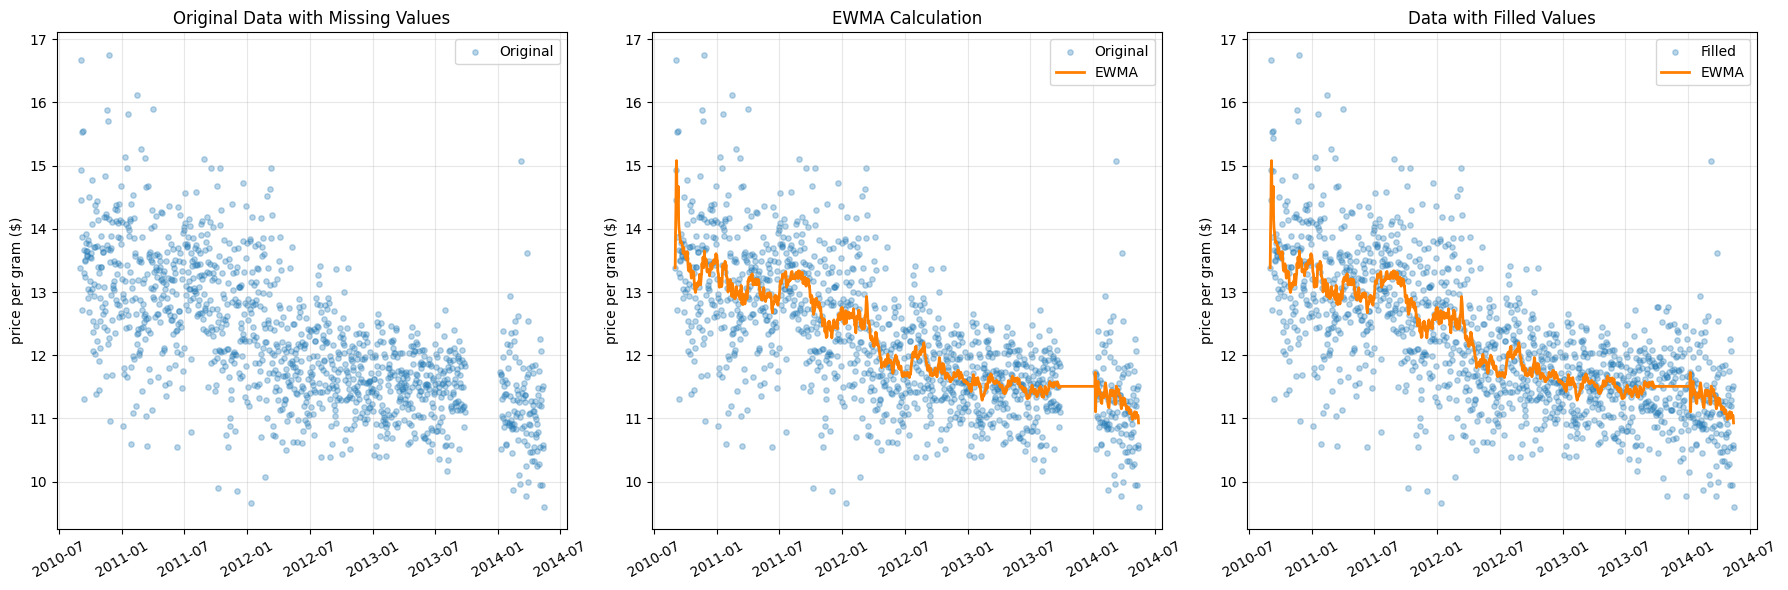

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Helper for uniform styling
def style_plot(ax, title):
    ax.set_title(title)
    ax.set_ylabel('price per gram ($)')
    ax.tick_params(axis='x', rotation=30)
    ax.legend()
    ax.grid(True, alpha=0.3)

# 1. Original data
ax1.scatter(reindexed.index, reindexed['ppg'], s=15, alpha=0.3, label='Original')
style_plot(ax1, 'Original Data with Missing Values')

# 2. EWMA
ax2.scatter(reindexed.index, reindexed['ppg'], s=15, alpha=0.3, label='Original')
ax2.plot(reindexed.index, ewma, color='#ff7f00', linewidth=2, label='EWMA')
style_plot(ax2, 'EWMA Calculation')

# 3. Filled data
ax3.scatter(reindexed.index, filled_data, s=15, alpha=0.3, label='Filled')
ax3.plot(reindexed.index, ewma, color='#ff7f00', linewidth=2, label='EWMA')
style_plot(ax3, 'Data with Filled Values')

plt.tight_layout()
plt.show()

Here's what the EWMA model looks like with missing values filled.

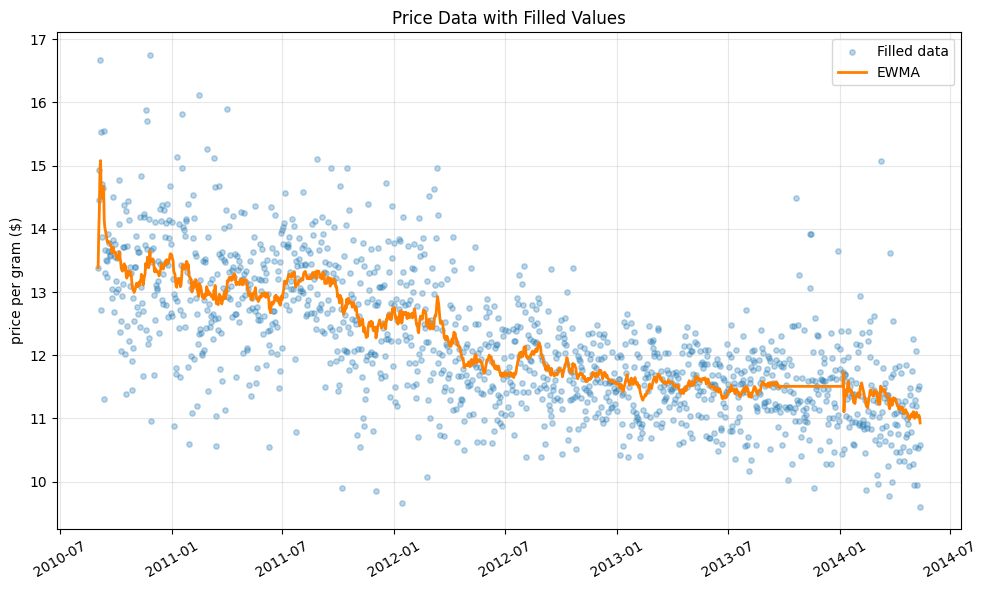

In [24]:
# Get high quality data
daily = dailies['high']

# Create figure
plt.figure(figsize=(10, 6))

# Create date range and reindex data
dates = pd.date_range(daily.index.min(), daily.index.max())
reindexed = daily.reindex(dates)

# Calculate EWMA
ewma = pd.Series(reindexed.ppg).ewm(span=30).mean()

# Fill missing values
resid = (reindexed.ppg - ewma).dropna()
fake_data = ewma + np.random.choice(resid, len(reindexed))
filled_data = reindexed.ppg.fillna(fake_data)

# Create the plot
plt.scatter(reindexed.index, filled_data, s=15, alpha=0.3, label='Filled data')
plt.plot(reindexed.index, ewma, color='#ff7f00', label='EWMA', linewidth=2)

# Configure plot
plt.title('Price Data with Filled Values')
plt.ylabel('price per gram ($)')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Serial correlation

The following function computes serial correlation with the given lag.

In [25]:
# for name, daily in dailies.items():
#     # Create date range and reindex data
#     dates = pd.date_range(daily.index.min(), daily.index.max())
#     reindexed = daily.reindex(dates)
#
#     # Calculate EWMA
#     ewma = reindexed.ppg.ewm(span=30).mean()
#
#     # Fill missing values
#     # residuals and resampled data
#     resid = (reindexed.ppg - ewma).dropna()
#     fake_data = ewma + np.random.choice(resid, len(reindexed))
#     filled_data = reindexed.ppg.fillna(fake_data)
#
#     # Calculate correlation between consecutive days
#     current = filled_data[1:]
#     previous = filled_data.shift(1)[1:]
#     corr = np.corrcoef(current, previous)[0,1]
#
#     print(name, f'{corr:.3f}')


It's not surprising that there are correlations between consecutive days, because there are obvious trends in the data.

It is more interested to see whether there are still correlations after we subtract away the trends.

In [26]:
# for name, daily in dailies.items():
#     # Create date range and reindex data
#     dates = pd.date_range(daily.index.min(), daily.index.max())
#     reindexed = daily.reindex(dates)
#
#     # Calculate EWMA
#     ewma = pd.Series(reindexed.ppg).ewm(span=30).mean()
#
#     # Calculate residuals (deviations from trend)
#     resid = (reindexed.ppg - ewma).dropna()
#
#     # Calculate serial correlation - get current and lagged values
#     current = resid[1:]  # all values except first
#     lagged = resid.shift(1)[1:]  # all values except first, shifted by 1
#
#     # Calculate correlation coefficient using numpy
#     corr = np.corrcoef(current, lagged)[0,1]  # [0,1] gets the correlation from the matrix
#     print(f"{name}: {corr:.3f}")


Even if the correlations between consecutive days are weak, there might be correlations across intervals of one week, one month, or one year.

In [27]:
# # Print header
# print("Lag\tHigh\tMedium\tLow")
#
# # Process each lag
# for lag in [1, 7, 30, 365]:
#     print(f"{lag}", end="\t")
#
#     # Process each quality level
#     for name in ['high', 'medium', 'low']:
#         daily = dailies[name]
#
#         # Create date range and reindex data
#         dates = pd.date_range(daily.index.min(), daily.index.max())
#         reindexed = daily.reindex(dates)
#
#         # Calculate EWMA
#         ewma = pd.Series(reindexed.ppg).ewm(span=30).mean()
#
#         # Calculate residuals (deviations from trend)
#         resid = (reindexed.ppg - ewma).dropna()
#
#         # Calculate correlation for this lag
#         current = resid[lag:]
#         lagged = resid.shift(lag)[lag:]
#         corr = np.corrcoef(current.dropna(), lagged.dropna())[0,1]
#
#         # Print in scientific notation format
#         print(f"{corr:.2g}", end="\t")
#
#     print()  # New line after each lag


In [28]:
def compute_residuals(daily, span=30):
    """
    Computes residuals from EWMA trend on daily PPG data.

    Parameters:
        daily (pd.DataFrame): Time-indexed DataFrame with a 'ppg' column.
        span (int): Span for EWMA smoothing.

    Returns:
        pd.Series: Residuals (ppg - EWMA), dropping NaNs.
    """
    if 'ppg' not in daily.columns:
        raise ValueError("Expected column 'ppg' in input DataFrame.")

    # Reindex with full date range
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    # EWMA smoothing
    ewma = reindexed['ppg'].ewm(span=span).mean()

    # Residuals (difference from trend)
    return (reindexed['ppg'] - ewma).dropna()


def compute_filled_correlation(daily, span=30):
    """
    Computes serial correlation of filled PPG data using EWMA + random residuals.

    Parameters:
        daily (pd.DataFrame): Time-indexed DataFrame with a 'ppg' column.
        span (int): Span for EWMA smoothing.

    Returns:
        float: Serial correlation (lag-1) of filled PPG series.
    """
    if 'ppg' not in daily.columns:
        raise ValueError("Expected column 'ppg' in input DataFrame.")

    # Reindex with full date range
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    # EWMA smoothing
    ewma = reindexed['ppg'].ewm(span=span).mean()

    # Residuals for noise generation
    resid = (reindexed['ppg'] - ewma).dropna()

    # Generate noise for NaNs
    nan_mask = reindexed['ppg'].isna()
    noise = np.random.choice(resid, size=nan_mask.sum(), replace=True)

    # Fill missing values with EWMA + noise
    filled_data = reindexed['ppg'].copy()
    filled_data[nan_mask] = ewma[nan_mask] + noise

    # Serial correlation (lag-1)
    current = filled_data[1:]
    previous = filled_data.shift(1)[1:]
    return np.corrcoef(current, previous)[0, 1]

def serial_corr(series, lag=1):
    """
    Computes the serial correlation of a series.
    Matches the implementation of the original SerialCorr function.

    Parameters:
        series: Series - the time series data
        lag: integer - number of intervals to shift

    Returns:
        float: correlation coefficient
    """
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    # Use numpy's corrcoef for correlation calculation
    return np.corrcoef(xs.dropna(), ys.dropna())[0, 1]



Here are the serial correlations for raw price data.

In [29]:
# Example 1: Serial Correlation Lag-1 (filled)
# Filling missing data allows full-series analysis with no dropped days
for name, daily in dailies.items():
    corr = compute_filled_correlation(daily)
    print(f"{name}: {corr:.3f}")

high: 0.495
low: 0.107
medium: 0.178


It's not surprising that there are correlations between consecutive days, because there are obvious trends in the data.

It is more interested to see whether there are still correlations after we subtract away the trends.

In [30]:
# Example 2: Serial Correlation after subtracting trends
# Analyze raw residuals (without filling) to preserve natural deviations
for name, daily in dailies.items():
    resid = compute_residuals(daily)
    corr = serial_corr(resid, lag=1)
    print(f"{name}: {corr:.3f}")

high: -0.014
low: 0.046
medium: -0.016


Even if the correlations between consecutive days are weak, there might be correlations across intervals of one week, one month, or one year.

In [31]:
# Example 3: Serial correlation at multiple lags (unfilled)
print("Lag\tHigh\tMedium\tLow")
for lag in [1, 7, 30, 365]:
    print(f"{lag}", end="\t")
    for name in ['high', 'medium', 'low']:
        resid = compute_residuals(dailies[name])
        corr = serial_corr(resid, lag)
        print(f"{corr:.2g}", end="\t")
    print()

Lag	High	Medium	Low
1	-0.014	-0.016	0.046	
7	0.0085	-0.046	-0.022	
30	0.011	-0.005	0.01	
365	0.074	0.048	-0.029	


The strongest correlation is (7.4%) for yearly cycle in the high quality category. This suggests a weak yearly seasonal pattern in the high quality prices after removing the trend.

## Autocorrelation

The autocorrelation function is the serial correlation computed for all lags.

We can use it to replicate the results from the previous section.

** need to revisit this implementation **

To get a sense of how much autocorrelation we should expect by chance, we can resample the data (which eliminates any actual autocorrelation) and compute the ACF.

The following function plots the actual autocorrelation for lags up to 40 days.

The flag `add_weekly` indicates whether we should add a simulated weekly cycle.

To show what a strong weekly cycle would look like, we have the option of adding a price increase of 1-2 dollars on Friday and Saturdays.

Here's what the real ACFs look like.  The gray regions indicate the levels we expect by chance.

Here's what it would look like if there were a weekly cycle.

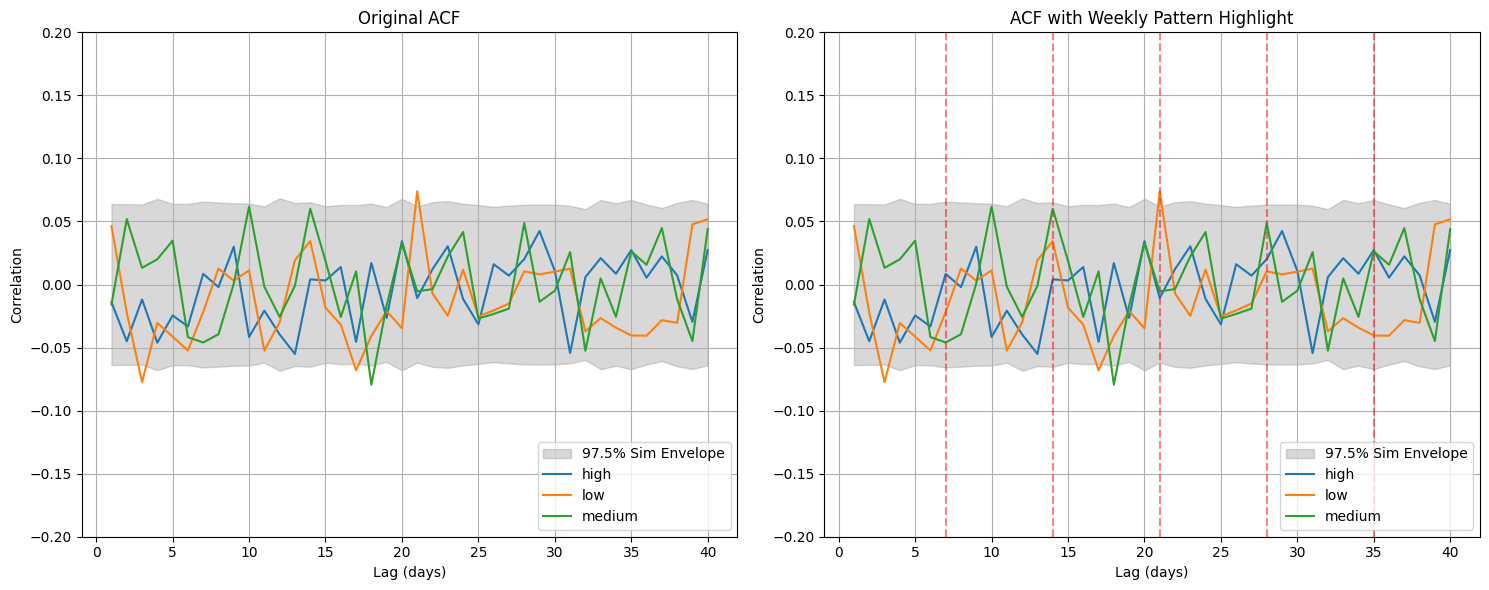

In [32]:
from statsmodels.tsa.stattools import acf

# --- Config ---
span = 30
nlags = 40
iters = 1001
category = "high"

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- First subplot: Original ACF ---
simulated_acfs = []
resid = compute_residuals(dailies[category], span=span)

for _ in range(iters):
    resampled = np.random.choice(resid, size=len(resid), replace=True)
    sim_acf = acf(resampled, nlags=nlags, fft=False, adjusted=True)[1:]
    simulated_acfs.append(np.abs(sim_acf))

simulated_acfs = np.array(simulated_acfs)
upper_bound = np.percentile(simulated_acfs, 97.5, axis=0)
lower_bound = -upper_bound
lags = np.arange(1, nlags + 1)

# Plot first subplot
ax1.fill_between(lags, lower_bound, upper_bound, color='gray', alpha=0.3, label='97.5% Sim Envelope')
for name, daily in dailies.items():
    resid = compute_residuals(daily, span=span)
    real_acf = acf(resid, nlags=nlags, fft=False, adjusted=True)[1:]
    ax1.plot(lags, real_acf, label=name)

ax1.set_title("Original ACF")
ax1.set_xlabel("Lag (days)")
ax1.set_ylabel("Correlation")
ax1.set_ylim(-0.2, 0.2)
ax1.grid(True)
ax1.legend(loc='lower right')

# --- Second subplot: Weekly Pattern Highlight ---
# Same calculation but with weekly pattern emphasis
ax2.fill_between(lags, lower_bound, upper_bound, color='gray', alpha=0.3, label='97.5% Sim Envelope')
for name, daily in dailies.items():
    resid = compute_residuals(daily, span=span)
    real_acf = acf(resid, nlags=nlags, fft=False, adjusted=True)[1:]
    ax2.plot(lags, real_acf, label=name)

    # Add vertical lines for weekly patterns
    weekly_lags = np.arange(7, nlags + 1, 7)
    ax2.vlines(weekly_lags, -0.2, 0.2, colors='red', alpha=0.2, linestyles='--')

ax2.set_title("ACF with Weekly Pattern Highlight")
ax2.set_xlabel("Lag (days)")
ax2.set_ylabel("Correlation")
ax2.set_ylim(-0.2, 0.2)
ax2.grid(True)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [33]:
# only printed high residuals
# refactored_resid = compute_residuals(dailies['high'], span=30)
# refactored_acf = acf(refactored_resid, nlags=40, adjusted=True, fft=False)[1:]
# print("Refactored ACF:", refactored_acf)

In [34]:
# checking residuals for each category
for category in ['high', 'medium', 'low']:
    refactored_resid = compute_residuals(dailies[category], span=30)
    refactored_acf = acf(refactored_resid, nlags=40, adjusted=True, fft=False)[1:]
    print(f"\n{category.upper()} category:")
    print(f"ACF values: {refactored_acf}")



HIGH category:
ACF values: [-0.01405398 -0.04498594 -0.01187147 -0.04615295 -0.024501   -0.03327578
  0.00843711 -0.00200766  0.03000775 -0.04161474 -0.02074113 -0.03956024
 -0.05507055  0.00410636  0.0032309   0.01389589 -0.04546475  0.01709065
 -0.02652969  0.03440846 -0.01074474  0.01219502  0.03035939 -0.01147174
 -0.03155877  0.01608219  0.00704751  0.02018681  0.04244141  0.01085507
 -0.05439191  0.00584723  0.02093008  0.00852974  0.02728549  0.00544542
  0.02230743  0.00732256 -0.02960617  0.02733883]

MEDIUM category:
ACF values: [-0.01586602  0.05188537  0.01324022  0.02000771  0.03480917 -0.04169551
 -0.04596436 -0.03943968  0.00075583  0.06187005 -0.00180397 -0.02565216
 -0.00098018  0.06010849  0.01882409 -0.02574433  0.01041967 -0.0794619
 -0.01661426  0.03287836 -0.00537269 -0.0036645   0.02226251  0.04160789
 -0.02700748 -0.02332883 -0.01912959  0.04877659 -0.01369191 -0.00495947
  0.02571458 -0.05252969  0.00490184 -0.02563591  0.0262421   0.0156856
  0.04478025 -0.01

In [35]:
# def compare_acf_values(original_acf, refactored_acf):
#     """
#     Compare two sets of ACF values and return differences and statistics.
#     """
#     # Convert to numpy arrays for easier manipulation
#     orig = np.array(original_acf)
#     refac = np.array(refactored_acf)
#
#     # Calculate differences
#     diff = orig - refac
#
#     # Calculate statistics
#     max_diff = np.max(np.abs(diff))
#     mean_diff = np.mean(np.abs(diff))
#
#     return {
#         'max_difference': max_diff,
#         'mean_difference': mean_diff,
#         'differences': diff
#     }
#
# # Calculate differences for each category
# for category in ['high', 'medium', 'low']:
#     # Get residuals for original and refactored methods
#     original_resid = compute_filled_correlation(dailies[category], span=30)
#     refactored_resid = compute_residuals(dailies[category], span=30)
#
#     # Calculate ACF for both
#     original_acf = statsmodels.tsa.stattools.acf(original_resid, nlags=40, adjusted=True)[1:]
#     refactored_acf = statsmodels.tsa.stattools.acf(refactored_resid, nlags=40, adjusted=True)[1:]
#
#     # Compare values
#     comparison = compare_acf_values(original_acf, refactored_acf)
#
#     print(f"\n{category.upper()} category:")
#     print(f"Maximum absolute difference: {comparison['max_difference']:.6f}")
#     print(f"Mean absolute difference: {comparison['mean_difference']:.6f}")
#


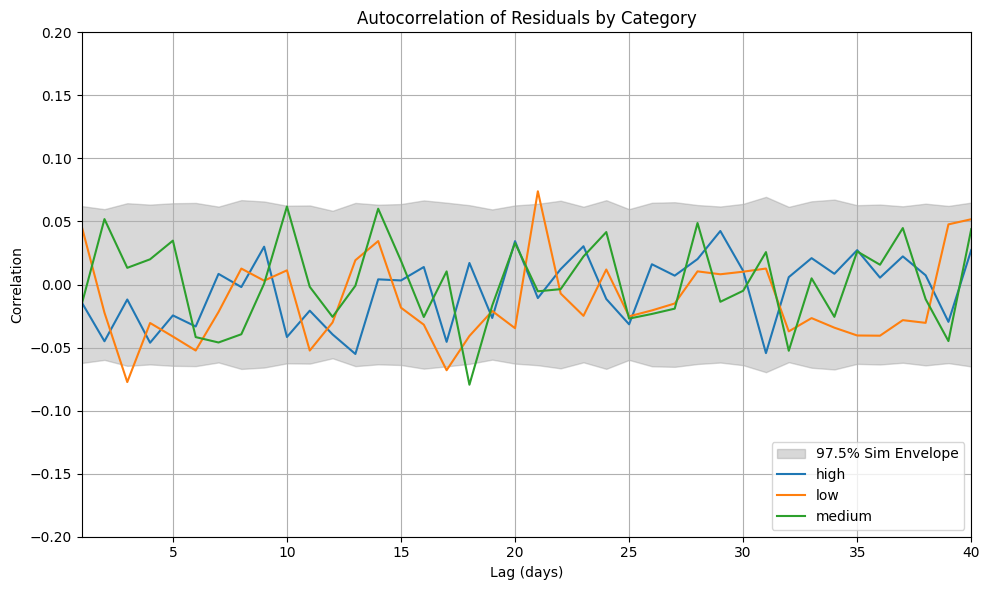

In [36]:
from statsmodels.tsa.stattools import acf

# --- Config ---
span = 30
nlags = 40
iters = 1001
category = "high"

# --- Simulation for ACF Envelope ---
simulated_acfs = []

resid = compute_residuals(dailies[category], span=span)
for _ in range(iters):
    resampled = np.random.choice(resid, size=len(resid), replace=True)
    sim_acf = acf(resampled, nlags=nlags, fft=False, adjusted=True)[1:]  # skip lag 0
    simulated_acfs.append(np.abs(sim_acf))

simulated_acfs = np.array(simulated_acfs)
upper_bound = np.percentile(simulated_acfs, 97.5, axis=0)
lower_bound = -upper_bound
lags = np.arange(1, nlags + 1)

# --- Plot Setup ---
plt.figure(figsize=(10, 6))
plt.fill_between(lags, lower_bound, upper_bound, color='gray', alpha=0.3, label='97.5% Sim Envelope')

# --- Actual ACF for each category ---
for name, daily in dailies.items():
    resid = compute_residuals(daily, span=span)
    real_acf = acf(resid, nlags=nlags, fft=False, adjusted=True)[1:]  # skip lag 0
    plt.plot(lags, real_acf, label=name)

# --- Final Touches ---
plt.title("Autocorrelation of Residuals by Category")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.ylim(-0.2, 0.2)
plt.xlim(1, nlags)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Prediction
simplest wat to generate is to fit linear model

In [37]:
def GenerateSimplePrediction(results, years):
    """
    Generate predictions from a quadratic regression model.

    Parameters:
        results: statsmodels fitted regression model
        years: sequence of floats or np.ndarray

    Returns:
        np.ndarray of predicted values
    """
    years = np.asarray(years)
    predict_df = pd.DataFrame({
        "Intercept": np.ones_like(years),
        "years": years,
        "years2": years**2
    })
    return results.predict(predict_df)

def PlotSimplePrediction(results, years, daily, name="", ax=None):
    """
    Plot observed data and quadratic predictions using matplotlib.

    Parameters:
        results: statsmodels regression results
        years: sequence of floats to predict over
        daily: pandas DataFrame with 'years' and 'ppg'
        name: label for the scatter plot
        ax: matplotlib axes object (optional)

    Returns:
        matplotlib Axes object
    """
    predict = GenerateSimplePrediction(results, years)

    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show_plot = True
    else:
        show_plot = False

    ax.scatter(daily["years"], daily["ppg"], alpha=0.2, label=f"{name} (observed)")
    ax.plot(years, predict, color="#ff7f00", label="Quadratic Fit")

    ax.set_title("Predicted Trend in Price per Gram")
    ax.set_xlabel("Years")
    ax.set_ylabel("Price per Gram ($)")
    ax.set_xlim(years[0] - 0.1, years[-1] + 0.1)
    ax.grid(True)
    ax.legend(loc="upper right")

    if show_plot:
        plt.tight_layout()
        plt.show()

    return ax


def RunLinearModel(daily):
    """
    Fits a quadratic regression model: ppg ~ years + years^2.

    Parameters:
        daily: DataFrame with 'years' and 'ppg' columns

    Returns:
        (model, results) from statsmodels
    """
    x = daily["years"]
    X = pd.DataFrame({
        "Intercept": 1,
        "years": x,
        "years2": x**2
    })

    y = daily["ppg"]
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

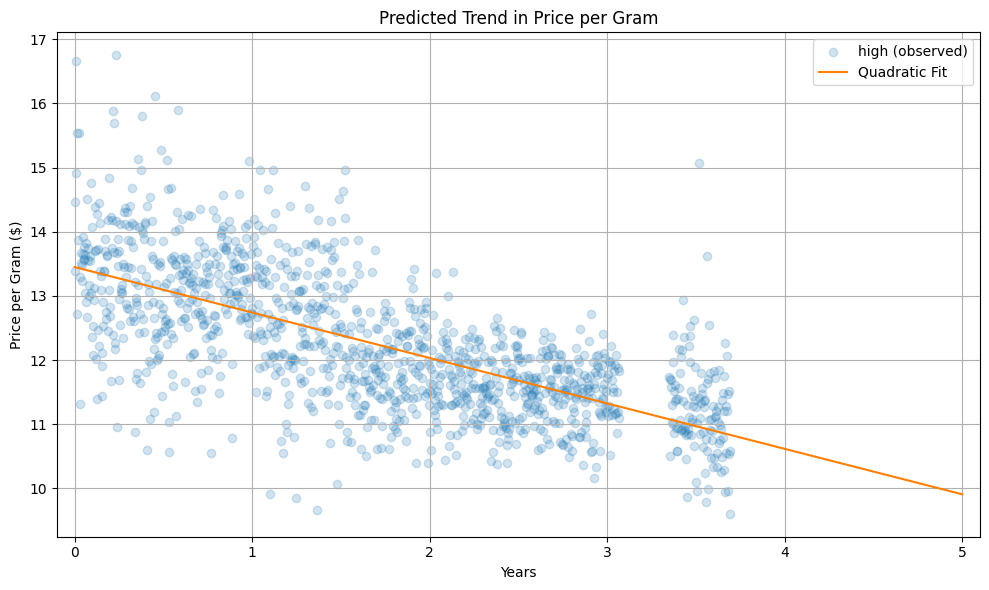

<Axes: title={'center': 'Predicted Trend in Price per Gram'}, xlabel='Years', ylabel='Price per Gram ($)'>

In [38]:
name = "high"
daily = dailies[name]

# Fit a quadratic model
_, results = RunLinearModel(daily)

# Predict over 0–5 years
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years, daily, name=name)

When we generate predictions, we want to quatify the uncertainty in the prediction.  We can do that by resampling.  The following function fits a model to the data, computes residuals, then resamples from the residuals to general fake datasets.  It fits the same model to each fake dataset and returns a list of results.

In [39]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """
    Run simulations by resampling residuals and refitting the model.

    Parameters:
        daily: DataFrame with 'years' and 'ppg'
        iters: number of simulations
        func: function that returns (model, results)

    Returns:
        List of statsmodels regression results
    """
    _, base_results = func(daily)
    residuals = base_results.resid
    fitted = base_results.fittedvalues
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake["ppg"] = fitted + np.random.choice(residuals, size=len(residuals), replace=True)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

To generate predictions, we take the list of results fitted to resampled data.  For each model, we use the `predict` method to generate predictions, and return a sequence of predictions.

If `add_resid` is true, we add resampled residuals to the predicted values, which generates predictions that include predictive uncertainty (due to random noise) as well as modeling uncertainty (due to random sampling).

In [40]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """
    Generate predictions from a list of fitted models.

    Parameters:
        result_seq: list of statsmodels regression results
        years: sequence of floats
        add_resid: if True, add bootstrapped residuals to simulate noise

    Returns:
        List of predicted values (one array per simulation)
    """
    predict_seq = []
    for results in result_seq:
        preds = GenerateSimplePrediction(results, years)
        if add_resid:
            preds += np.random.choice(results.resid, size=len(preds), replace=True)
        predict_seq.append(preds)
    return predict_seq

To Visualize predictions a darker region quatifies modeling uncertainty and a lighter region that quantifies predictive uncertainty.

In [41]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel, ax=None):
    """
    Plot confidence and prediction intervals using bootstrapped simulations.

    Parameters:
        daily: DataFrame with 'years' and 'ppg'
        years: sequence of float years to predict over
        iters: number of simulations
        percent: confidence level (e.g., 90)
        func: function that returns (model, results)
        ax: matplotlib Axes object (optional)

    Returns:
        matplotlib Axes object
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    alpha = (100 - percent) / 2

    # Prediction interval (with residuals)
    pred_seq = GeneratePredictions(result_seq, years, add_resid=True)
    pred_array = np.array(pred_seq)
    low_pred = np.percentile(pred_array, alpha, axis=0)
    high_pred = np.percentile(pred_array, 100 - alpha, axis=0)

    # Confidence interval (no residuals)
    conf_seq = GeneratePredictions(result_seq, years, add_resid=False)
    conf_array = np.array(conf_seq)
    low_conf = np.percentile(conf_array, alpha, axis=0)
    high_conf = np.percentile(conf_array, 100 - alpha, axis=0)

    # Create axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show_plot = True
    else:
        show_plot = False

    # Plot the intervals with adjusted colors and transparency
    ax.fill_between(years, low_pred, high_pred, alpha=0.3, color="orange", label="Prediction Interval")
    ax.fill_between(years, low_conf, high_conf, alpha=0.7, color="blue", label="Confidence Interval", linewidth=2)

    ax.legend(loc="upper right")

    if show_plot:
        plt.tight_layout()
        plt.show()

    return ax

#### Prediction based on linear fits, showing variation due to sampling and prediction error

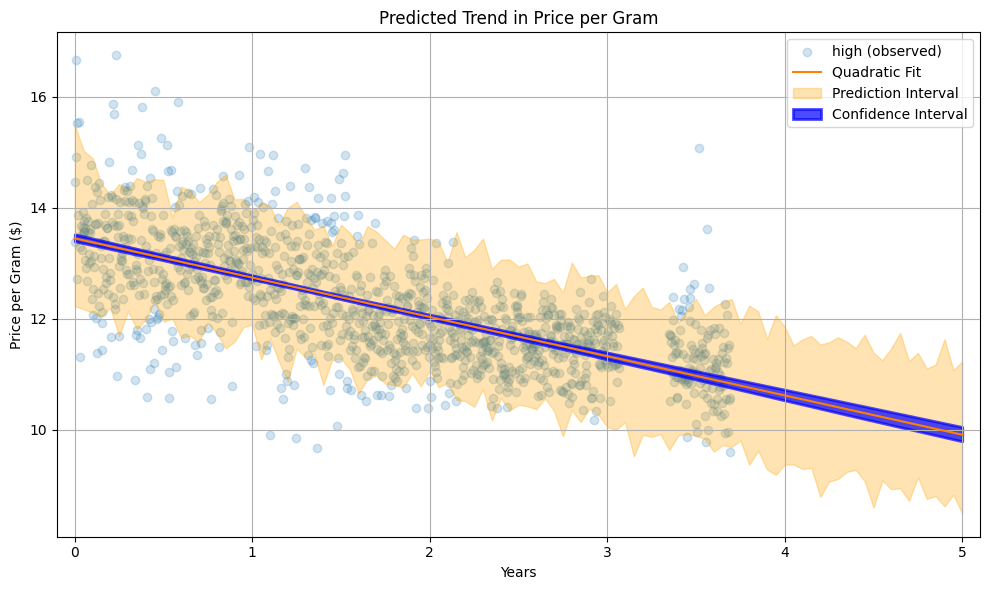

In [42]:
name = "high"
daily = dailies[name]
years = np.linspace(0, 5, 101)
_, results = RunLinearModel(daily)

fig, ax = plt.subplots(figsize=(10, 6))
PlotSimplePrediction(results, years, daily, name=name, ax=ax)
PlotPredictions(daily, years, iters=101, ax=ax)
plt.tight_layout()
plt.show()

But there is one more source of uncertainty: how much past data should we use to build the model?

The following function generates a sequence of models based on different amounts of past data.

In [43]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake["ppg"] = results.fittedvalues + np.random.choice(results.resid, size=len(results.resid), replace=True)
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel, ax=None):
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low = np.percentile(predict_seq, percents[0], axis=0)
    high = np.percentile(predict_seq, percents[1], axis=0)

    # Create axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show_plot = True
    else:
        show_plot = False

    ax.fill_between(years, low, high, alpha=0.2, color="gray", label="Prediction Interval")

    if show_plot:
        plt.tight_layout()
        plt.show()

    return ax

#### Predictions based on linear fits, showing variation due to the interval of observation

This takes into account uncertainty about how much past data to use.

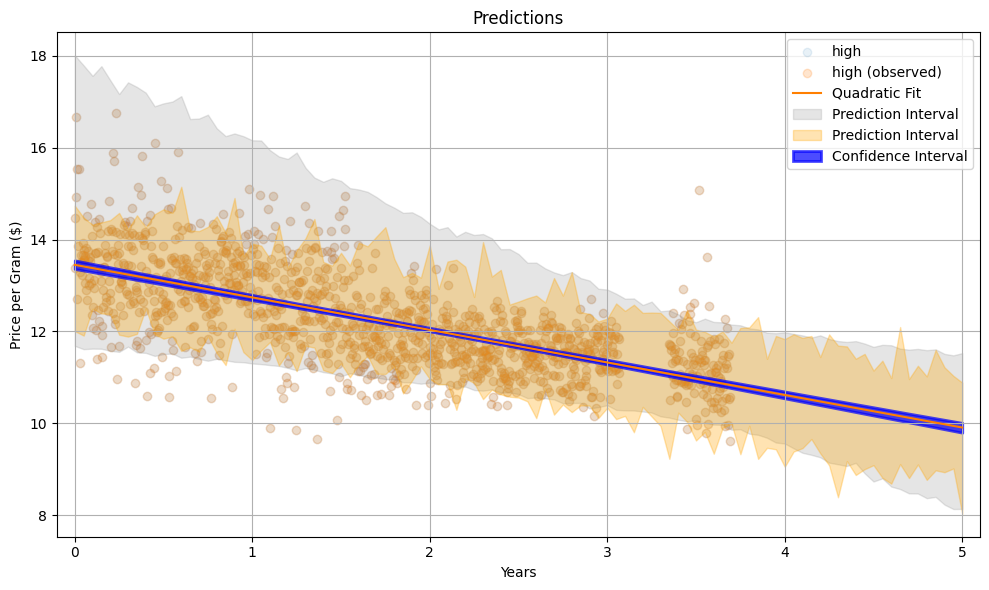

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(daily["years"], daily["ppg"], alpha=0.1, label=name)

PlotSimplePrediction(results, years, daily, name=name, ax=ax)
PlotIntervals(daily, years, iters=50, ax=ax)
PlotPredictions(daily, years, iters=50, ax=ax)

ax.set_xlim(years[0] - 0.1, years[-1] + 0.1)
ax.set_title("Predictions")
ax.set_xlabel("Years")
ax.set_ylabel("Price per Gram ($)")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Exercises


**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

### Extending EWMA for Time Series Predictions

There are several ways to extend the EWMA model to generate predictions. One of the simplest is something like this:

1. Compute the EWMA of the time series and use the last point as an intercept, `inter`.

2. Compute the EWMA of differences between successive elements in the time series and use the last point as a slope, `slope`.

3. To predict values at future times, compute `inter + slope * dt`, where `dt` is the difference between the time of the prediction and the time of the last observation.



In [45]:
def fill_missing_data(daily, span=30):
    """Fill missing values using EWMA and random sampling of residuals

    Args:
        daily: DataFrame with original data
        span: window size for EWMA calculation
    """
    # Create full date range and reindex
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    # Calculate EWMA
    ewma = reindexed['ppg'].ewm(span=span).mean()

    # Calculate and sample from residuals
    resid = reindexed['ppg'] - ewma
    non_null_resids = resid.dropna().values

    # Generate random residuals for missing values
    n_missing = reindexed['ppg'].isna().sum()
    random_resids = np.random.choice(non_null_resids, size=n_missing)

    # Fill missing values with EWMA + random residual
    missing_mask = reindexed['ppg'].isna()
    reindexed.loc[missing_mask, 'ppg'] = (
        ewma[missing_mask] + random_resids
    )

    # Calculate slope using difference in EWMA
    slope = ewma.diff()

    # Store all calculations
    filled = pd.DataFrame(index=dates)
    filled['ppg'] = reindexed['ppg']
    filled['ewma'] = ewma
    filled['slope'] = slope

    return filled



In [46]:
# ---- 1. Filter data for the specified date range ----
start_date = '2010-07-01'
end_date = '2014-07-31'

filled = fill_missing_data(daily)

# Now process the data in the correct sequence:

# 1. First compute all the EWMA and derivative columns on the full dataset
filled['ewma'] = filled['ppg'].ewm(span=30).mean()
filled['diff_ppg'] = filled['ppg'].diff()
filled['ewma_diff'] = filled['diff_ppg'].ewm(span=30).mean()

# 2. Then filter for the date range we want
start_date = '2010-07-01'
end_date = '2014-07-31'
filled_filtered = filled.loc[start_date:end_date].copy()


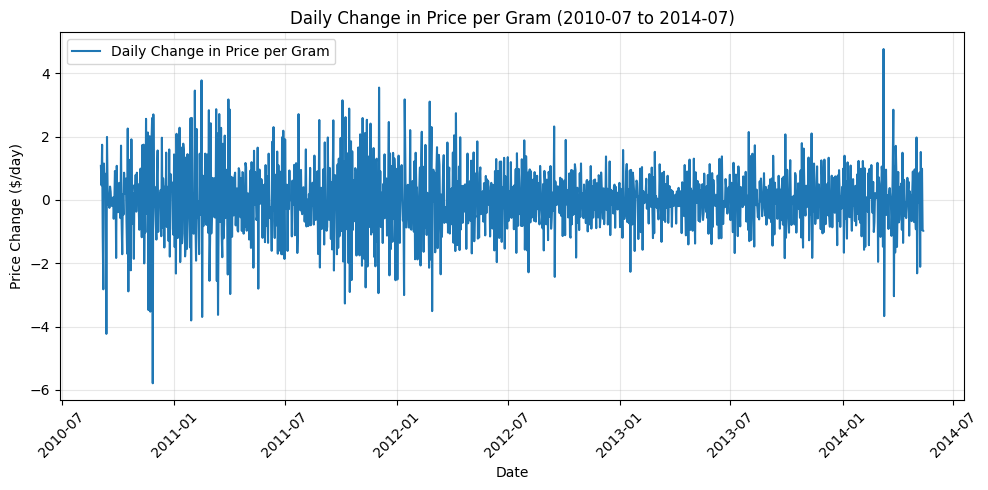

In [47]:
# Fill missing values first
filled_filtered['ppg'] = filled_filtered['ppg'].fillna(filled_filtered['ewma'])

# Calculate daily changes after filling missing values
filled_filtered['diff_ppg'] = filled_filtered['ppg'].diff()

# ---- PLOT 1: Daily Change in Price per Gram ----
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(filled_filtered.index, filled_filtered['diff_ppg'], color='C0', label="Daily Change in Price per Gram")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price Change ($/day)")
ax1.set_title("Daily Change in Price per Gram (2010-07 to 2014-07)")
ax1.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


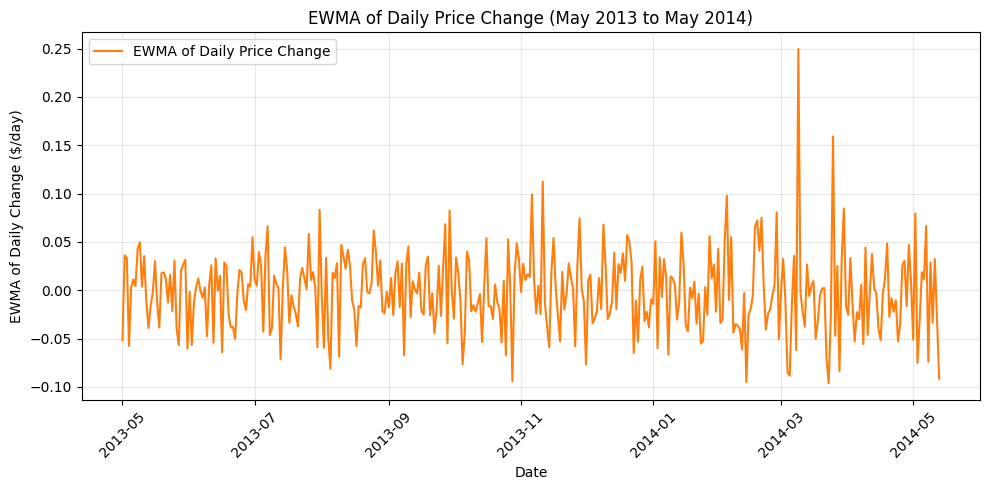

In [48]:
# ---- PLOT 2: EWMA of Daily Price Change ----
fig2, ax2 = plt.subplots(figsize=(10, 5))

# Define the new date range
start_date = '2013-05-01'
end_date = '2014-05-31'
filtered_period = filled_filtered[start_date:end_date]

ax2.plot(filtered_period.index, filtered_period['ewma_diff'],
         color='C1', label="EWMA of Daily Price Change")
ax2.set_xlabel("Date")
ax2.set_ylabel("EWMA of Daily Change ($/day)")
ax2.set_title("EWMA of Daily Price Change (May 2013 to May 2014)")
ax2.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()



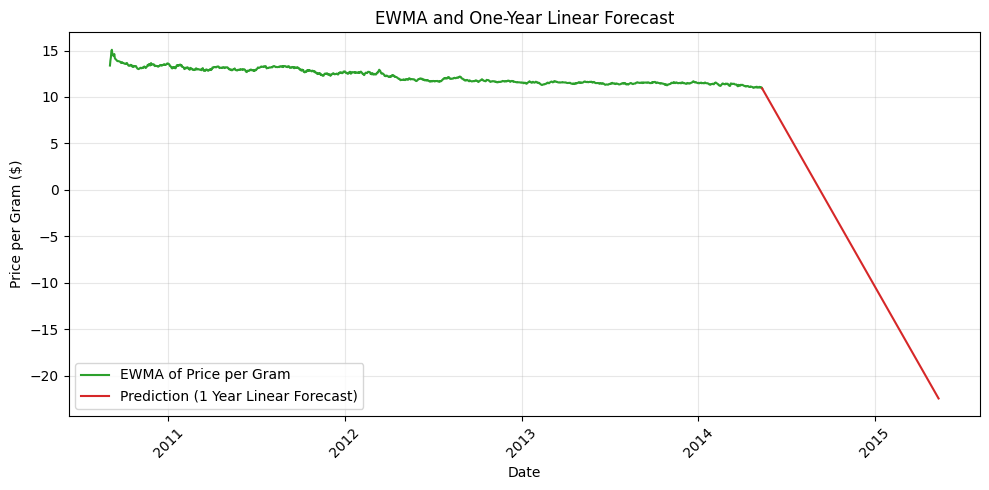

In [49]:
# ---- PLOT 3: Prediction ----
# Intercept and slope for linear forecast
inter = filled['ewma'].iloc[-1]
slope = filled['ewma_diff'].iloc[-1]

# Predict one year into the future
future_dates = pd.date_range(filled.index[-1], periods=366, freq='D')
dt = (future_dates - filled.index[-1]).days
predictions = inter + slope * dt

# Plot the EWMA and prediction
fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(filled.index, filled['ewma'], color='C2', label="EWMA of Price per Gram")
ax3.plot(future_dates, predictions, color='C3', label="Prediction (1 Year Linear Forecast)")
ax3.set_xlabel("Date")
ax3.set_ylabel("Price per Gram ($)")
ax3.set_title("EWMA and One-Year Linear Forecast")
ax3.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The resulting slope has quite an aggressive sloep that doesnt match the data. Lets increase our window from 1 day to 30 days

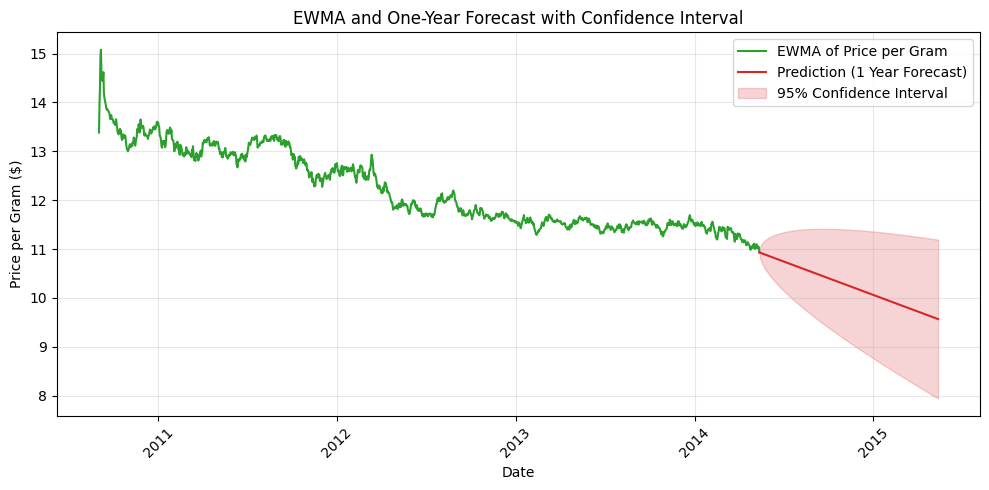

In [50]:
# ---- PLOT 3: Prediction with Smoothed Slope ----
# Calculate slope using a longer window of data (e.g., last 30 days)
window = 30
recent_ewma = filled['ewma'].iloc[-window:]
recent_dates = (recent_ewma.index - recent_ewma.index[0]).days


# Fit a line to recent data to get a more stable slope
coeffs = np.polyfit(recent_dates, recent_ewma.values, 1)
slope = coeffs[0]  # slope from linear fit
inter = filled['ewma'].iloc[-1]  # Keep last value as intercept

# Predict one year into the future
future_dates = pd.date_range(filled.index[-1], periods=366, freq='D')
dt = (future_dates - filled.index[-1]).days
predictions = inter + slope * dt

# Plot with confidence intervals
fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(filled.index, filled['ewma'], color='C2', label="EWMA of Price per Gram")
ax3.plot(future_dates, predictions, color='C3', label="Prediction (1 Year Forecast)")

# Add confidence intervals (±2 std of recent changes)
std_dev = filled['ewma_diff'].tail(window).std()
ax3.fill_between(future_dates,
                 predictions - 2 * std_dev * np.sqrt(dt),
                 predictions + 2 * std_dev * np.sqrt(dt),
                 color='C3', alpha=0.2, label="95% Confidence Interval")

ax3.set_xlabel("Date")
ax3.set_ylabel("Price per Gram ($)")
ax3.set_title("EWMA and One-Year Forecast with Confidence Interval")
ax3.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


### Model Breakdown

#### Trend Metrics

In [51]:
# Calculate trend over the analysis period
total_change = filled['ewma'].iloc[-1] - filled['ewma'].iloc[0]
percent_change = (total_change / filled['ewma'].iloc[0]) * 100

# Calculate annualized rate of change
days_elapsed = (filled.index[-1] - filled.index[0]).days
annual_rate = (percent_change / days_elapsed) * 365

# Calculate recent trend (last 30 days)
recent_slope = coeffs[0]  # from our previous calculation
daily_change_rate = recent_slope
annual_projected_change = daily_change_rate * 365

print(f"Historical Metrics:")
print(f"Total Change: ${total_change:.2f}")
print(f"Total Percent Change: {percent_change:.1f}%")
print(f"Annualized Rate of Change: {annual_rate:.1f}%")
print(f"\nRecent Trend (30-day window):")
print(f"Daily Rate of Change: ${daily_change_rate:.3f}/day")
print(f"Projected Annual Change: ${annual_projected_change:.2f}")


Historical Metrics:
Total Change: $-2.45
Total Percent Change: -18.3%
Annualized Rate of Change: -5.0%

Recent Trend (30-day window):
Daily Rate of Change: $-0.004/day
Projected Annual Change: $-1.36


#### Volatility

In [52]:
# Calculate volatility metrics
daily_volatility = filled['ewma_diff'].std()
rolling_volatility = filled['ewma_diff'].rolling(window).std().iloc[-1]

# Calculate confidence intervals
confidence_95_next_month = 2 * rolling_volatility * np.sqrt(30)
confidence_95_next_year = 2 * rolling_volatility * np.sqrt(365)

print(f"\nVolatility Metrics:")
print(f"Daily Volatility: ${daily_volatility:.3f}")
print(f"30-day Rolling Volatility: ${rolling_volatility:.3f}")
print(f"95% Confidence Interval (1 month): ±${confidence_95_next_month:.2f}")
print(f"95% Confidence Interval (1 year): ±${confidence_95_next_year:.2f}")



Volatility Metrics:
Daily Volatility: $0.072
30-day Rolling Volatility: $0.043
95% Confidence Interval (1 month): ±$0.47
95% Confidence Interval (1 year): ±$1.63


#### Model Quality

In [53]:
# Calculate forecast accuracy metrics
mae = np.abs(filled['ewma'] - filled['ppg']).mean()
rmse = np.sqrt(((filled['ewma'] - filled['ppg']) ** 2).mean())
mape = (np.abs(filled['ewma'] - filled['ppg']) / filled['ppg']).mean() * 100

print(f"\nModel Quality Metrics:")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Square Error: ${rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.1f}%")



Model Quality Metrics:
Mean Absolute Error: $0.56
Root Mean Square Error: $0.74
Mean Absolute Percentage Error: 4.6%


#### Summary Statistics

In [54]:
# Calculate basic statistics
stats = filled['ppg'].describe()
ewma_stats = filled['ewma'].describe()

print(f"\nPrice Summary Statistics:")
print(f"Average Price: ${stats['mean']:.2f}")
print(f"Median Price: ${stats['50%']:.2f}")
print(f"Price Range: ${stats['min']:.2f} - ${stats['max']:.2f}")
print(f"Standard Deviation: ${stats['std']:.2f}")



Price Summary Statistics:
Average Price: $12.17
Median Price: $11.98
Price Range: $9.60 - $16.75
Standard Deviation: $1.09
